<h1> [FIAD] Projeto I </h1>

Este projeto pretende aplicar métodos de fusão de dados para a localização de um robot, considerando
que é representado por um modelo não-linear e que possui um sensor de velocidade, um giroscópio 
e um sensor de GNSS (Global Navigation Satellite System).

São analisados e comparados 3 filtros diferentes:
    <ul>
        <li> Extended Kalman Filter
        <li> Unscented Kalman Filter
        <li> Particle Filter
    </ul>

<h3> 0. Bibliotecas utilizadas </h3>

Nesta secção estão listadas as bibliotecas utilizadas no desenvolvimento do código necessário para implementar e analisar os filtros supramencionados.
A linha 4 remete ao ficheiro 'utils.py', que contém todas as funções desenvolvidas que ajudam na execução do código.

In [11]:
import numpy as np
from math import sqrt, cos, sin, ceil
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
from utils import *

<h3> 1. Parâmetros globais </h3>

In [12]:
# Estimation params for EKF
Q = np.diag([0.1, 0.1, np.deg2rad(1.0), 1.0]) ** 2
R = np.diag([1.0, 1.0]) ** 2

# Sim params
gps_noise = np.diag([0.5, 0.5]) ** 2
input_noise = np.diag([1.0, np.deg2rad(30.0)]) ** 2

dt = 0.1
sim_time = 50.0

#  UKF params
ALPHA = 0.001
BETA = 2
KAPPA = 0

<h3> 2. Filtros </h3>

<h4> 2.0. Dead Reckoning </h4>

Este algoritmo calcula a posição atual usando a posição anterior e incorpora as estimativas de velocidade e direção ao longo do tempo.

<h4> 2.1. Extended Kalman Filter </h4>

O Extended Kalman Filter (EKF) é uma versão não-linear do Kalman Filter, i.e, funciona de maneira análoga ao Kalman Filter mas aplica-se a sistemas não-lineares. <br/>
Este algoritmo converte o sistema não-linear num sistema linear (através de matrizes jacobianas), para, de seguida, obter previsões dos valores (tal como é feito no Kalman Filter).

Este filtro compreende 4 fases:
<ul>
    <li>Inicialização</li>
    <li>
        Previsão <br />
        <img src='../images/prediction-ekf.jpg'></img>
    </li>
    <li>
        Medição <br />
        <img src='../images/measurement-ekf.jpg'></img>
    </li>
    <li>Repetir a previsão e medição até terminar a simulação</li>
</ul>



In [13]:
def main():
    print('Initiated robot sim!')
    
    time = 0.

    # vetor de estados [x, y, yaw, v]
    xpred = np.zeros((4, 1))    
    xtrue = np.zeros((4, 1))    
    ppred = np.eye(4)

    # dead reckoning
    xdr = np.zeros((4, 1))

    # histórico
    hxpred = xpred
    hxtrue = xtrue
    hxdr = xtrue
    hz = np.zeros((1, 2))

    fig = plt.figure()
    fig.show()
    
    # for gif
    imgs = []

    while time <= sim_time:
        time += dt

        xtrue, z, xdr, ud = observation(xtrue, xdr, u())
        xpred, ppred = ekf(xpred, ppred, z, ud)

        # guardar no histórico
        hxpred, hxtrue, hxdr, hz = save(
            hxpred, xpred, hxtrue, xtrue,
            hxdr, xdr, hz, z
        )

    plt.plot(hz[:, 0], hz[:, 1], ".g")
    plt.plot(hxtrue[0, :].flatten(),
                hxtrue[1, :].flatten(), "-b")
    plt.plot(hxdr[0, :].flatten(),
                hxdr[1, :].flatten(), "-k")
    plt.plot(hxpred[0, :].flatten(),
                hxpred[1, :].flatten(), "-r")
    plt.axis("equal")
    plt.grid(True)

    # gif
    # filename = f'{time * 1/dt}.jpeg'
    # imgs.append(f'./frames/{filename}')
    # plt.savefig(filename)


Initiated robot sim!


C:\Users\MANUEL~1\AppData\Local\Temp/ipykernel_19956/3372032095.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


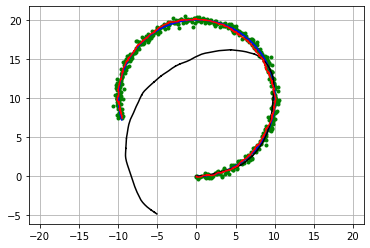

In [14]:
main()